In [2]:
import cv2
import glob
import itertools
import math
import pickle
from datetime import datetime
from pathlib import Path
import random
import os
import datetime
import json
import time

import numpy as np
import pandas as pd
from PIL import Image
from scipy import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import keras.backend as K
from keras.callbacks import LearningRateScheduler

import albumentations as A
from sklearn.model_selection import KFold

In [3]:
%load_ext autoreload
%autoreload 2
from annotationChecker.AnnotationData import AnnotationData
import JMBAG_detector
import albumentations as A

In [1]:
data_folder = "D:/FER/diplomski_rad/data"

In [4]:
image_size = (128,128)
batch_size = 64

k_folds = 5

org_prob_values = [0.3, 0.5, 0.7]
channels_values = [
    [16, 16, 32, 64],
    [32, 32, 64, 128],
    [64, 64, 128, 256]
]
final_channel_values = [16, 32, 64]
dropouts_values = [None, 0.1, 0.3]

learning_rate = 0.0015
decay_rate = 0.9
decay_step = 20
epochs = 150

In [5]:
def loadAnnotation(input_folder):
    data = []
    paths = glob.glob(input_folder + "/**/*.pkl", recursive=True)
    for path in paths:
        with open(path, "rb") as file:
            annotations = pickle.load(file)
        annotationsArray = [(str(Path(path).parent) + "\\" + name, ant) for (name, ant) in annotations]
        data += annotationsArray
    return data

In [6]:
annotation = loadAnnotation(data_folder)

In [7]:
len(annotation)

1709

In [8]:
annotation[0]

('D:\\FER\\diplomski_rad\\data\\studentidmatrix-dataset01\\dataset01\\p0000001.png',
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8))

In [9]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, image_size, transform = None):
        self.image_size = image_size
        self.data = data
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size: (idx + 1) * self.batch_size]
        images = np.array([self.load_image(name) for (name, ant) in batch_data], dtype=np.float32)
        annotation = np.array([np.expand_dims(ant.astype(np.float32), -1) for (name, ant) in batch_data])
        return images, annotation 
    
    def on_epoch_end(self):
        random.shuffle(self.data)
            
    def load_image(self, path, transform=None):
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.image_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        img = np.expand_dims(img, axis=-1)
        return img
 

In [10]:
whole_dataset = Dataset(annotation, batch_size, image_size=image_size)

In [11]:
whole_dataset[0][1][0][...,-1]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [12]:
AnnotationData.convertAnnotationToStr(whole_dataset[0][1][0])

'0036519620'

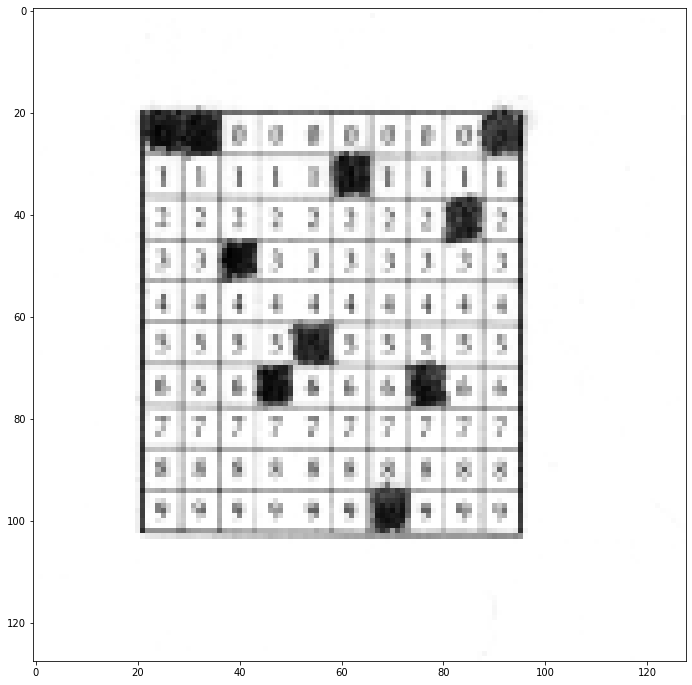

In [13]:
fig = plt.figure(figsize=(12., 12.))
plt.imshow(whole_dataset[0][0][0][...,-1], cmap=plt.get_cmap('gray'))

In [14]:
train_transform = A.Compose([
    A.Rotate(limit=(-6,6), p=0.4,mask_value=1),
    A.ShiftScaleRotate(p=0.3, shift_limit=0.0, scale_limit=0.1, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1),
    A.ShiftScaleRotate(p=0.3, shift_limit=0.1, scale_limit=0.00, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1)
])

In [15]:
probabilities = [ t.p for t in train_transform]
p = lambda x: abs( np.prod([1- x * p for p in probabilities]) -  org_prob_values[0])
minimum = optimize.golden(p, brack=(0, 1e-6)) #1 / max(probabilities)
print("Optimization factor", minimum)
for t in train_transform:
    new_p = t.p * minimum
    if new_p < 0 or new_p > 1:
        raise ValueError("new P is outside of probability limits, new_p = "+ str(new_p))
    t.p = new_p

print("Adjusted probablities" ,[ str(t.p) for t in train_transform])

Optimization factor 0.986695051130857
Adjusted probablities ['0.3946780204523428', '0.2960085153392571', '0.2960085153392571']


In [16]:
kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)
fold_datasets = []
folds = kf.split(annotation)
for fold, (train_indices, test_indices) in enumerate(folds):
    train_data = [annotation[i] for i in train_indices]
    test_data = [annotation[i] for i in test_indices]
    train_dataset = Dataset(train_data, batch_size, image_size, train_transform)
    test_dataset = Dataset(test_data, batch_size, image_size)
    fold_datasets.append((train_dataset, test_dataset))

In [17]:
train_dataset = fold_datasets[0][0]
val_dataset = fold_datasets[0][1]

In [18]:
print("Number of training example", len(train_dataset.data))
print("Number of validation example", len(val_dataset.data))

Number of training example 1367
Number of validation example 342


In [19]:
batch = random.randint(0, len(train_dataset))
batch

12

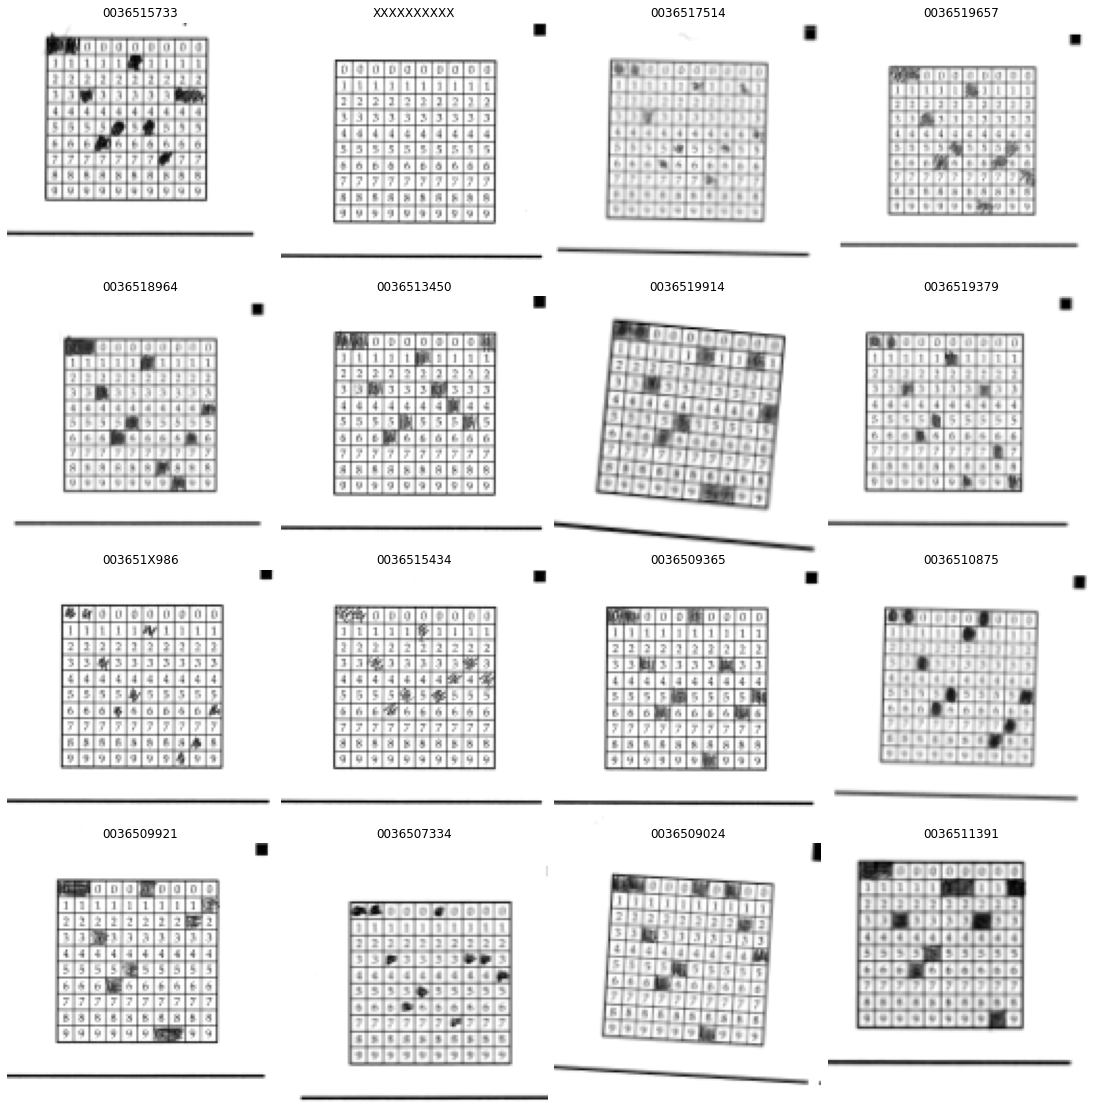

In [20]:
data = train_dataset[batch][:][:16]
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),
                 axes_pad=0.1 
                 )

for ax, im,ant in zip(grid, data[0], data[1]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im[...,-1], cmap = "gray")
    ax.set_title(AnnotationData.convertAnnotationToStr(ant[...,-1]))
    ax.axis("off")

plt.show()

In [21]:
def absolute_accuracy(y_true, y_pred, round_value = 0.5):
    y_pred = tf.where(tf.greater(y_pred, round_value), tf.ones_like(y_pred), tf.zeros_like(y_pred))
    equal = tf.equal(y_true, y_pred)
    result = tf.cast(tf.reduce_all(equal, axis=[1, 2, 3]), tf.int8)
    return result

In [22]:
def lr_scheduler(epoch, lr):
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [23]:
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

In [24]:
model = JMBAG_detector.model(image_size, in_channels=1,out_channels=1,channels=channels_values[2], final_channel=final_channel_values[2], dropout=dropouts_values[-1])
model.summary()

Model: "Modified U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           leaky_re_lu[0][0]                
_____________________________________________________________________________________

In [25]:
def alpha_accuracy(y_true, y_pred):
    y_pred_round = tf.round(y_pred)
    reduce_sum = tf.reduce_sum(y_pred_round, axis=[1, -1])
    indexes = tf.squeeze(tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1)))
    values = absolute_accuracy(y_true[indexes], y_pred[indexes])
    return indexes.numpy(), values

def beta_accuracy(y_true, y_pred):
    reduce_sum = tf.reduce_sum(y_true, axis=[1, -1])
    indexes = tf.squeeze(tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1)))
    values = absolute_accuracy(y_true[indexes], y_pred[indexes])
    return indexes.numpy(), values

In [130]:
def train_model_on_Kfold(folder, dropout, channels, final_channel, org_prob):
    # Create main folder based on timestamp
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    

    # Save arguments in the root folder's text file
    info_txt = os.path.join(folder, "info.txt")
    info = f"dropout={dropout}/channels={channels}/final_channel={final_channel}/org_prob={org_prob}"
    with open(info_txt, "a") as f:
        f.write(f"{timestamp}\t {info}\n")

    # Create subfolder structure
    training_folder = f"{folder}/{timestamp}"
    os.makedirs(training_folder, exist_ok=True)
    results_txt = os.path.join(training_folder, "results.txt")

    train_transform = A.Compose([
    A.Rotate(limit=(-6,6), p=0.4,mask_value=1),
    A.ShiftScaleRotate(p=0.3, shift_limit=0.0, scale_limit=0.1, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1),
    A.ShiftScaleRotate(p=0.3, shift_limit=0.1, scale_limit=0.00, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1)
    ])

    # Save arguments in the root folder's text file
    with open(results_txt, "w") as f:
        f.write(f"timestamp: {timestamp}\n")
        f.write(f"Dropout: {dropout}\n")
        f.write(f"Channels: {channels}\n")
        f.write(f"Final Channel: {final_channel}\n")
        f.write(f"Org Prob: {org_prob}\n\n")
        f.write("Other parameters\n")
        f.write(f"Image size: {image_size}\n")
        f.write(f"Batch size: {batch_size}\n")
        f.write(f"k_folds: {k_folds}\n")
        f.write(f"learning_rate: {learning_rate}\n")
        f.write(f"decay_rate: {decay_rate}\n")
        f.write(f"decay_step: {decay_step}\n")
        f.write(f"epochs: {epochs}\n\n")
        f.write(f"Transforms: {train_transform}\n\n")
    
    

    probabilities = [ t.p for t in train_transform]
    p = lambda x: abs( np.prod([1- x * p for p in probabilities]) -  org_prob)
    minimum = optimize.golden(p, brack=(0, 1e-6)) #1 / max(probabilities)
    print("Optimization factor", minimum)
    for t in train_transform:
        new_p = t.p * minimum
        if new_p < 0 or new_p > 1:
            raise ValueError("new P is outside of probability limits, new_p = "+ str(new_p))
        t.p = new_p

    print("Adjusted probablities" ,[ str(t.p) for t in train_transform])

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    fold_datasets = []
    folds = kf.split(annotation)
    for fold, (train_indices, test_indices) in enumerate(folds):
        train_data = [annotation[i] for i in train_indices]
        test_data = [annotation[i] for i in test_indices]
        train_dataset = Dataset(train_data, batch_size, image_size, transform=train_transform)
        test_dataset = Dataset(test_data, batch_size, image_size)
        fold_datasets.append((train_dataset, test_dataset))

    val_acc_mean_collected = []
    train_acc_mean_collected = []

    val_alpha_mean_collected = []
    train_alpha_mean_collected = []

    val_beta_mean_collected = []
    train_beta_mean_collected = []

    
    

    for i in range(k_folds):
        print("Fold", i)
        train_dataset = fold_datasets[i][0]
        val_dataset = fold_datasets[i][1]
        
        #Initialize and train the Keras model
        model = models.model(image_size, in_channels=1,out_channels=1,channels=channels, final_channel=final_channel, dropout=dropout)
        # Add your model architecture and training code here
        opt = optimizers.Adam(learning_rate=learning_rate, clipnorm = 0.1)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[absolute_accuracy])
        history = model.fit(train_dataset,validation_data=val_dataset, epochs=epochs, callbacks=callbacks)

        # Save training history as JSON
        history_json = os.path.join(training_folder, f"history_fold_{i}.json")
        with open(history_json, "w") as f:
            json.dump(str(model.history.history), f)
        
        train_dataset_withot_transform = Dataset(train_dataset.data, batch_size, image_size)
        
        all_train_pred = np.array(list(itertools.chain(*[model.predict(x[0]) for x in train_dataset_withot_transform])))
        all_train_true = np.array(list(itertools.chain(*[x[1] for x in train_dataset_withot_transform])))

        all_val_pred = np.array(list(itertools.chain(*[model.predict(x[0]) for x in val_dataset])))
        all_val_true = np.array(list(itertools.chain(*[x[1] for x in val_dataset])))

        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False,axis =[1,2,3], reduction=tf.keras.losses.Reduction.NONE)
        all_val_loss = bce(all_val_true, all_val_pred).numpy()

        val_acc = absolute_accuracy(all_val_true, all_val_pred).numpy()
        train_acc = absolute_accuracy(all_train_true, all_train_pred).numpy()

        val_acc_zeros_set = set(np.argwhere(val_acc < 1).flatten())
        train_acc_zeros_set = set(np.argwhere(train_acc < 1).flatten())

        val_acc_mean = sum(val_acc) / len(val_acc)
        train_acc_mean = sum(train_acc) / len(train_acc)

        val_acc_mean_collected.append(val_acc_mean)
        train_acc_mean_collected.append(train_acc_mean)
    
        with open(results_txt, "a") as f:
            f.write(f"Results from fold {i}\n")
            f.write(f"Validation accuracy: {sum(val_acc)}/{len(val_acc)} ({val_acc_mean})\n")
            f.write(f"Traininig accuracy: {sum(train_acc)}/{len(train_acc)} ({train_acc_mean})\n\n")

        val_indexes, val_alpha = alpha_accuracy(all_val_true, all_val_pred)
        val_alpha = val_alpha.numpy()
        train_indexes, train_alpha = alpha_accuracy(all_train_true, all_train_pred)
        train_alpha = train_alpha.numpy()

        val_alpha_zeros_set = set(val_indexes[np.argwhere(val_alpha < 1).flatten()])
        train_alpha_zeros_set = set(train_indexes[np.argwhere(train_alpha < 1).flatten()])

        val_alpha_mean = sum(val_alpha) / len(val_alpha)
        train_alpha_mean = sum(train_alpha) / len(train_alpha)

        val_alpha_mean_collected.append(val_alpha_mean)
        train_alpha_mean_collected.append(train_alpha_mean)
    
        with open(results_txt, "a") as f:
            f.write(f"Validation alpha: {sum(val_alpha)}/{len(val_alpha)} ({val_alpha_mean})\n")
            f.write(f"Traininig alpha: {sum(train_alpha)}/{len(train_alpha)} ({train_alpha_mean})\n\n")

        val_indexes, val_beta = beta_accuracy(all_val_true, all_val_pred)
        val_beta = val_beta.numpy()
        train_indexes, train_beta = beta_accuracy(all_train_true, all_train_pred)
        train_beta = train_beta.numpy()

        val_beta_zeros_set = set(val_indexes[np.argwhere(val_beta < 1).flatten()])
        train_beta_zeros_set = set(train_indexes[np.argwhere(train_beta < 1).flatten()])

        val_beta_mean = sum(val_beta) / len(val_beta)
        train_beta_mean = sum(train_beta) / len(train_beta)

        val_beta_mean_collected.append(val_beta_mean)
        train_beta_mean_collected.append(train_beta_mean)
    
        with open(results_txt, "a") as f:
            f.write(f"Validation beta: {sum(val_beta)}/{len(val_beta)} ({val_beta_mean})\n")
            f.write(f"Traininig beta: {sum(train_beta)}/{len(train_beta)} ({train_beta_mean})\n\n")
        

        full_summary = os.path.join(training_folder, f"full_summary_fold_{i}.txt")
        with open(full_summary, "a") as f:
            for i, (path, ann) in enumerate(val_dataset.data):
                true_ann_str = AnnotationData.convertAnnotationToStr(ann)
                pred_ann_str = AnnotationData.convertAnnotationToStr(np.round(all_val_pred[i][...,-1]))
                false_predicted = i in val_acc_zeros_set
                alpha_error = i in val_alpha_zeros_set
                beta_error = i in val_beta_zeros_set
                loss = all_val_loss[i]
                f.write(f"{path},validation,{true_ann_str},{pred_ann_str},{false_predicted},{alpha_error},{beta_error},{loss}\n")

            for i, (path, ann) in enumerate(train_dataset_withot_transform.data):
                true_ann_str = AnnotationData.convertAnnotationToStr(ann)
                pred_ann_str = AnnotationData.convertAnnotationToStr(np.round(all_train_pred[i][...,-1]))
                false_predicted = i in train_acc_zeros_set
                alpha_error = i in train_alpha_zeros_set
                beta_error = i in train_beta_zeros_set
                f.write(f"{path},training,{true_ann_str},{pred_ann_str},{false_predicted},{alpha_error},{beta_error},null,\n")


    with open(results_txt, "a") as f:
        f.write("Total results:\n")
        f.write(f"Val Accuracy mean: {np.mean(val_acc_mean_collected)}\n")
        f.write(f"Train Accuracy mean: {np.mean(train_acc_mean_collected)}\n")
        f.write(f"Val Alpha mean: {np.mean(val_alpha_mean_collected)}\n")
        f.write(f"Train Alpha mean: {np.mean(train_alpha_mean_collected)}\n")
        f.write(f"Val Beta mean: {np.mean(val_beta_mean_collected)}\n")
        f.write(f"Train Beta mean: {np.mean(train_beta_mean_collected)}\n")

    

In [131]:
train_model_on_Kfold("./results", dropouts_values[-1], channels_values[-1], final_channel_values[-1], org_prob_values[-2])

Optimization factor 0.6172705889627702
Adjusted probablities ['0.2469082355851081', '0.18518117668883105', '0.18518117668883105']
Fold 0
Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 15s 337ms/step - loss: 0.4279 - absolute_accuracy: 0.0037 - val_loss: 0.2349 - val_absolute_accuracy: 0.0000e+00
Epoch 1 Elapsed Time: 14.7711 seconds
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 7s 289ms/step - loss: 0.1846 - absolute_accuracy: 7.3153e-04 - val_loss: 0.2001 - val_absolute_accuracy: 0.0000e+00
Epoch 2 Elapsed Time: 6.5030 seconds
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 6s 266ms/step - loss: 0.1715 - absolute_accuracy: 0.0000e+00 - val_loss: 0.1993 - val_absolute_accuracy: 0.0000e+00
Epoch 3 Elapsed Time: 5.9336 second

In [137]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_validation_loss(
        history_files, 
        measurements, 
        target_value,
        figure_size=(14, 10), 
        title='Validation Loss Comparison', 
        xlabel='Epochs', 
        ylabel='Validation Loss', epoch_range=None, xticks_step=15):

    plt.figure(figsize=figure_size)  # Set the figure size

    for i, history_file in enumerate(history_files):
        # Load the history data from the training session
        with open(history_file, "r") as f:
            history_data = json.load(f)
        history_data = eval(history_data)  # Convert the string back to a dictionary

        # Extract the validation loss values
        val_loss = history_data[target_value]
        if epoch_range is not None:
            val_loss = val_loss[epoch_range[0]:epoch_range[1]]
            epochs = range(epoch_range[0], len(val_loss) + epoch_range[0])
        else:
            epochs = range(1, len(val_loss) + 1)

        # Plot the validation loss
        plt.plot(epochs, val_loss, label=measurements[i])

    # Set x-axis tick marks every xticks_step epochs
    xticks = np.arange(epoch_range[0], len(val_loss) + epoch_range[0] + 1, xticks_step)
    plt.xticks(xticks)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

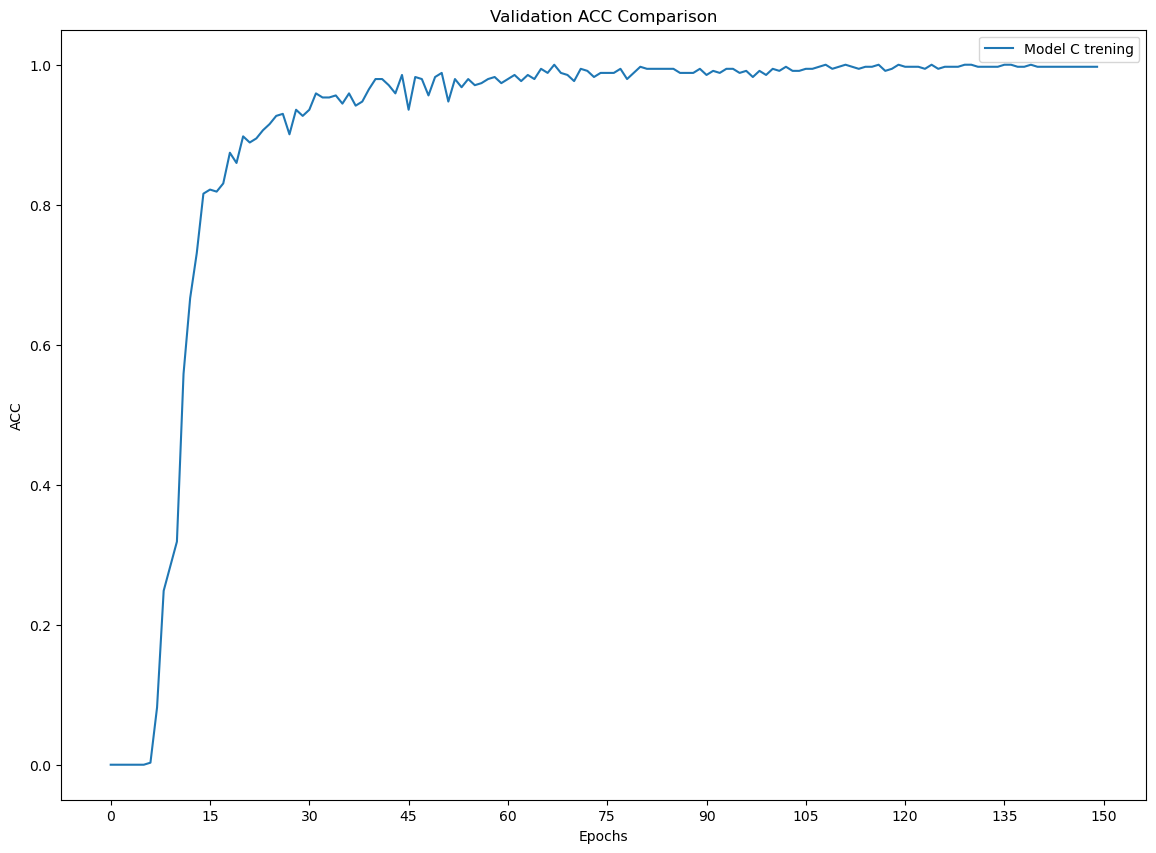

In [138]:

# Define the arguments
history_files = [
    'D:/FER/diplomski_rad/code/results/2023-06-18_12-30-50/history_fold_0.json',
]
measurements = [
    'Model C trening'
]
target_value = 'val_absolute_accuracy'
title = 'Validation ACC Comparison'
xlabel = 'Epochs'
ylabel = 'ACC'
epoch_range = (0, 150)  # Specify the range from epoch 30 to the end (if None, plot all epochs)
xticks_step = 15  # Set the x-axis tick marks every 15 epochs

# Call the method with the arguments
plot_validation_loss(history_files, measurements, target_value, title=title, xlabel=xlabel, ylabel=ylabel, epoch_range=epoch_range, xticks_step=xticks_step)

In [29]:
# Step 1: Load the CSV files into separate DataFrames
directory_path = 'D:/FER/diplomski_rad/code/results/2023-06-18_12-30-50/'  # Update with the appropriate directory path
csv_files = glob.glob(directory_path + 'full*.txt')
dataframes = []
for file in csv_files:
    df = pd.read_csv(file, names=['file','set','true_label','predited_label','ACC','alpha','beta','loss'],)
    dataframes.append(df)

# Step 2: Concatenate the separate DataFrames into a single DataFrame
combined_df = pd.concat(dataframes)
# Step 3: Filter the combined DataFrame based on the desired conditions
filtered_df = combined_df[(combined_df['set'] == 'validation') & (combined_df['ACC'] == True)]


# Step 4: Access the examples that satisfy the filter
files = list(filtered_df.file)

In [30]:
filtered_df

,file,set,true_label,predited_label,ACC,alpha,beta,loss
305,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,003[36][56][15][19]251,003[36]5[15][19]251,True,False,False,0.025687
214,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,0036517605,00[23]65[15]X[67][08][59],True,False,True,0.232667
218,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,003[56][15]18665,0036[15]18665,True,False,False,0.150333
221,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,003[36]511893,0036511893,True,True,False,0.037444
259,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,0246080077,0XX6080077,True,False,True,0.033103
305,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,0036519379,[03][06][13]47[16]9379,True,False,True,0.416329
38,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,0[03][36]6499562,00[36]6499562,True,False,False,0.065472
191,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,XXXXXXXXXX,003652[02]0[25]1,True,False,False,1.576833
209,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,00X3651603,00X365[16][06][03][36],True,False,False,0.175765
228,D:\FER\diplomski_rad\data\studentidmatrix-data...,validation,036513606X,03[36]5136066,True,False,False,0.050136


In [27]:
len(files)

23

In [31]:
filtered_annotation = [a for a in annotation if a[0] in files]

In [32]:
filtered_dataset = Dataset(filtered_annotation, 128, image_size)
filtered_images = filtered_dataset[0][0]

Wrong predicted, hard examples

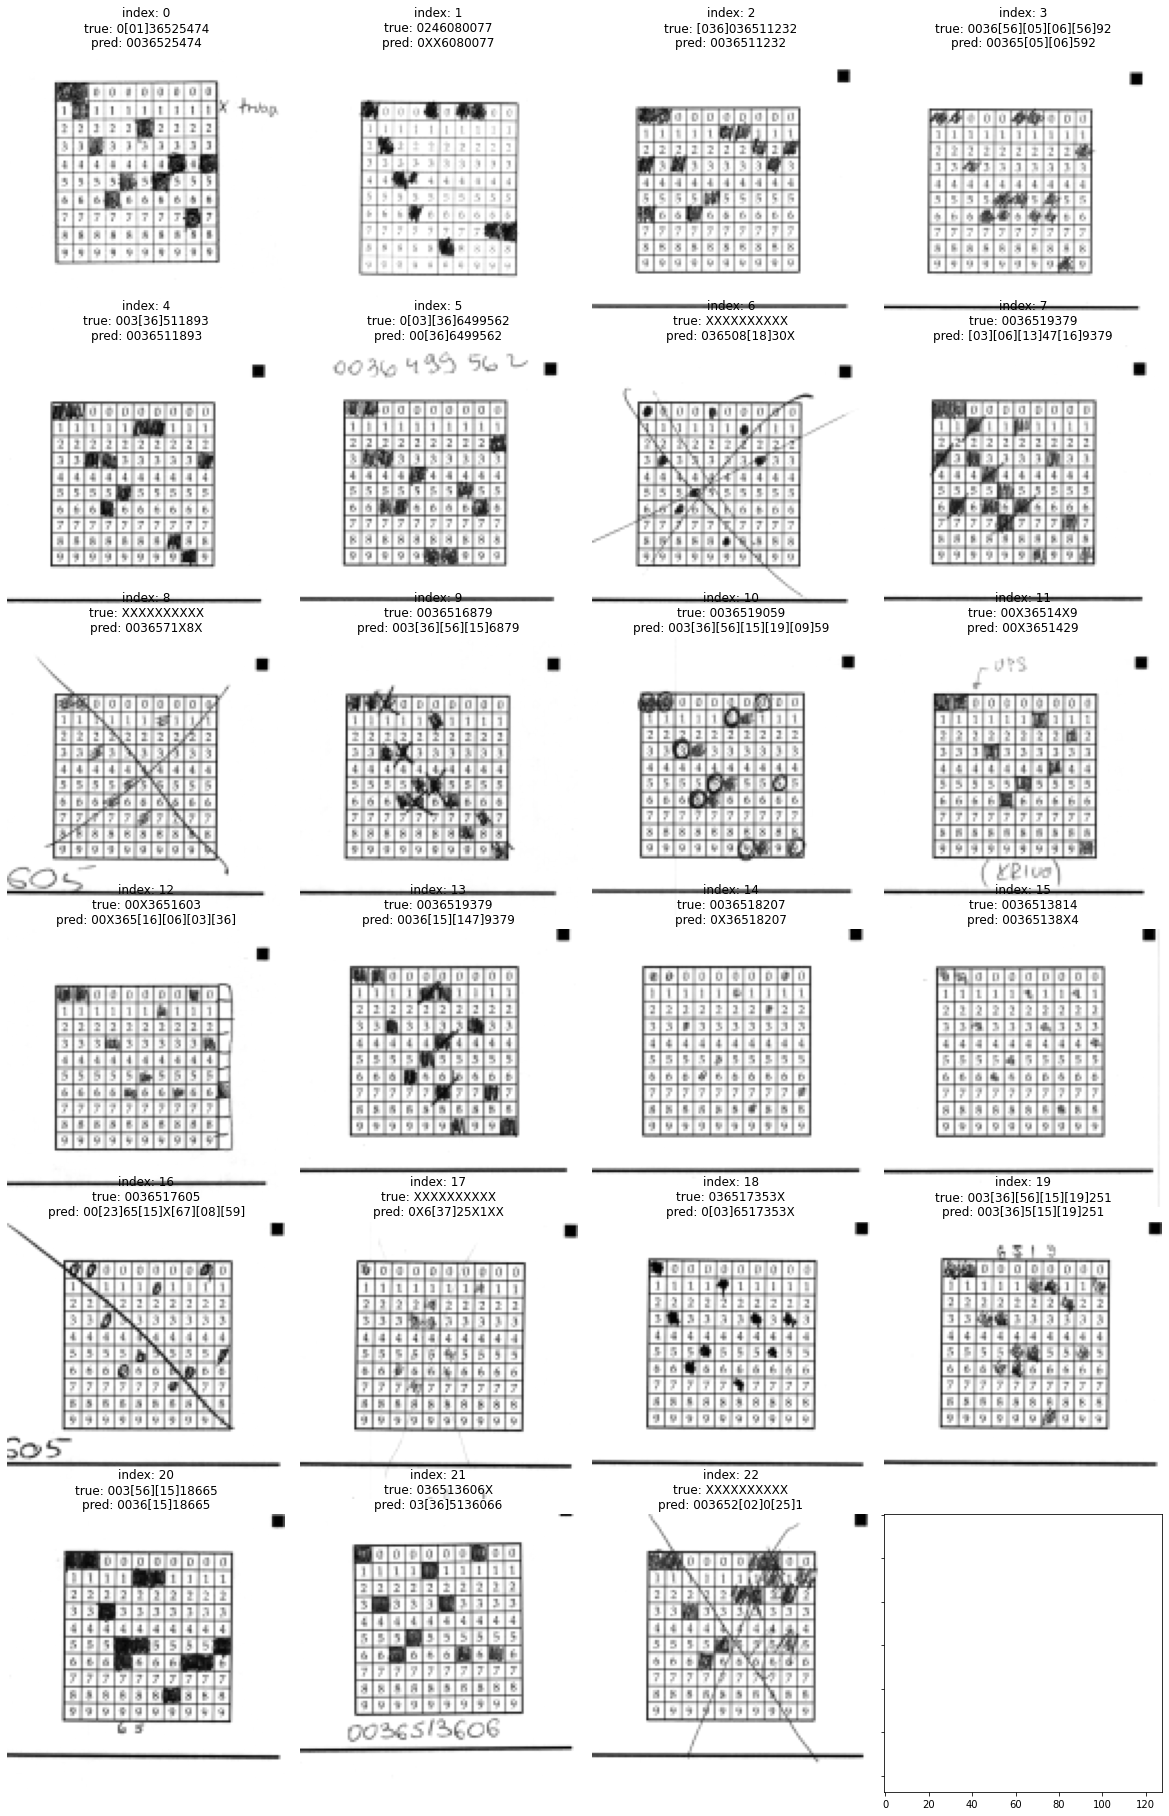

In [39]:
fig = plt.figure(figsize=(24., 32.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 4),
                 axes_pad=0.2 
                 )

for index, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    if index >= len(filtered_annotation): break
    ax.imshow(filtered_images[index][...,-1], cmap = "gray")
    true_str = filtered_df.loc[filtered_df['file'] == filtered_annotation[index][0], 'true_label'].values[0]
    pred_str = filtered_df.loc[filtered_df['file'] == filtered_annotation[index][0], 'predited_label'].values[0]
    ax.set_title(f"index: {index}\ntrue: {true_str}\npred: {pred_str}")
    ax.axis("off")

plt.show()

In [47]:
filtered_df = combined_df[(combined_df['set'] == 'validation') & (combined_df['ACC'] == False)]
filtered_df = filtered_df.sort_values(by='loss', ascending=False)
filtered_df = filtered_df.head(32)
files = list(filtered_df.file)

In [44]:
filtered_annotation = [a for a in annotation if a[0] in files]

In [45]:
filtered_dataset = Dataset(filtered_annotation, 128, image_size)
filtered_images = filtered_dataset[0][0]

true prediction, hard examples

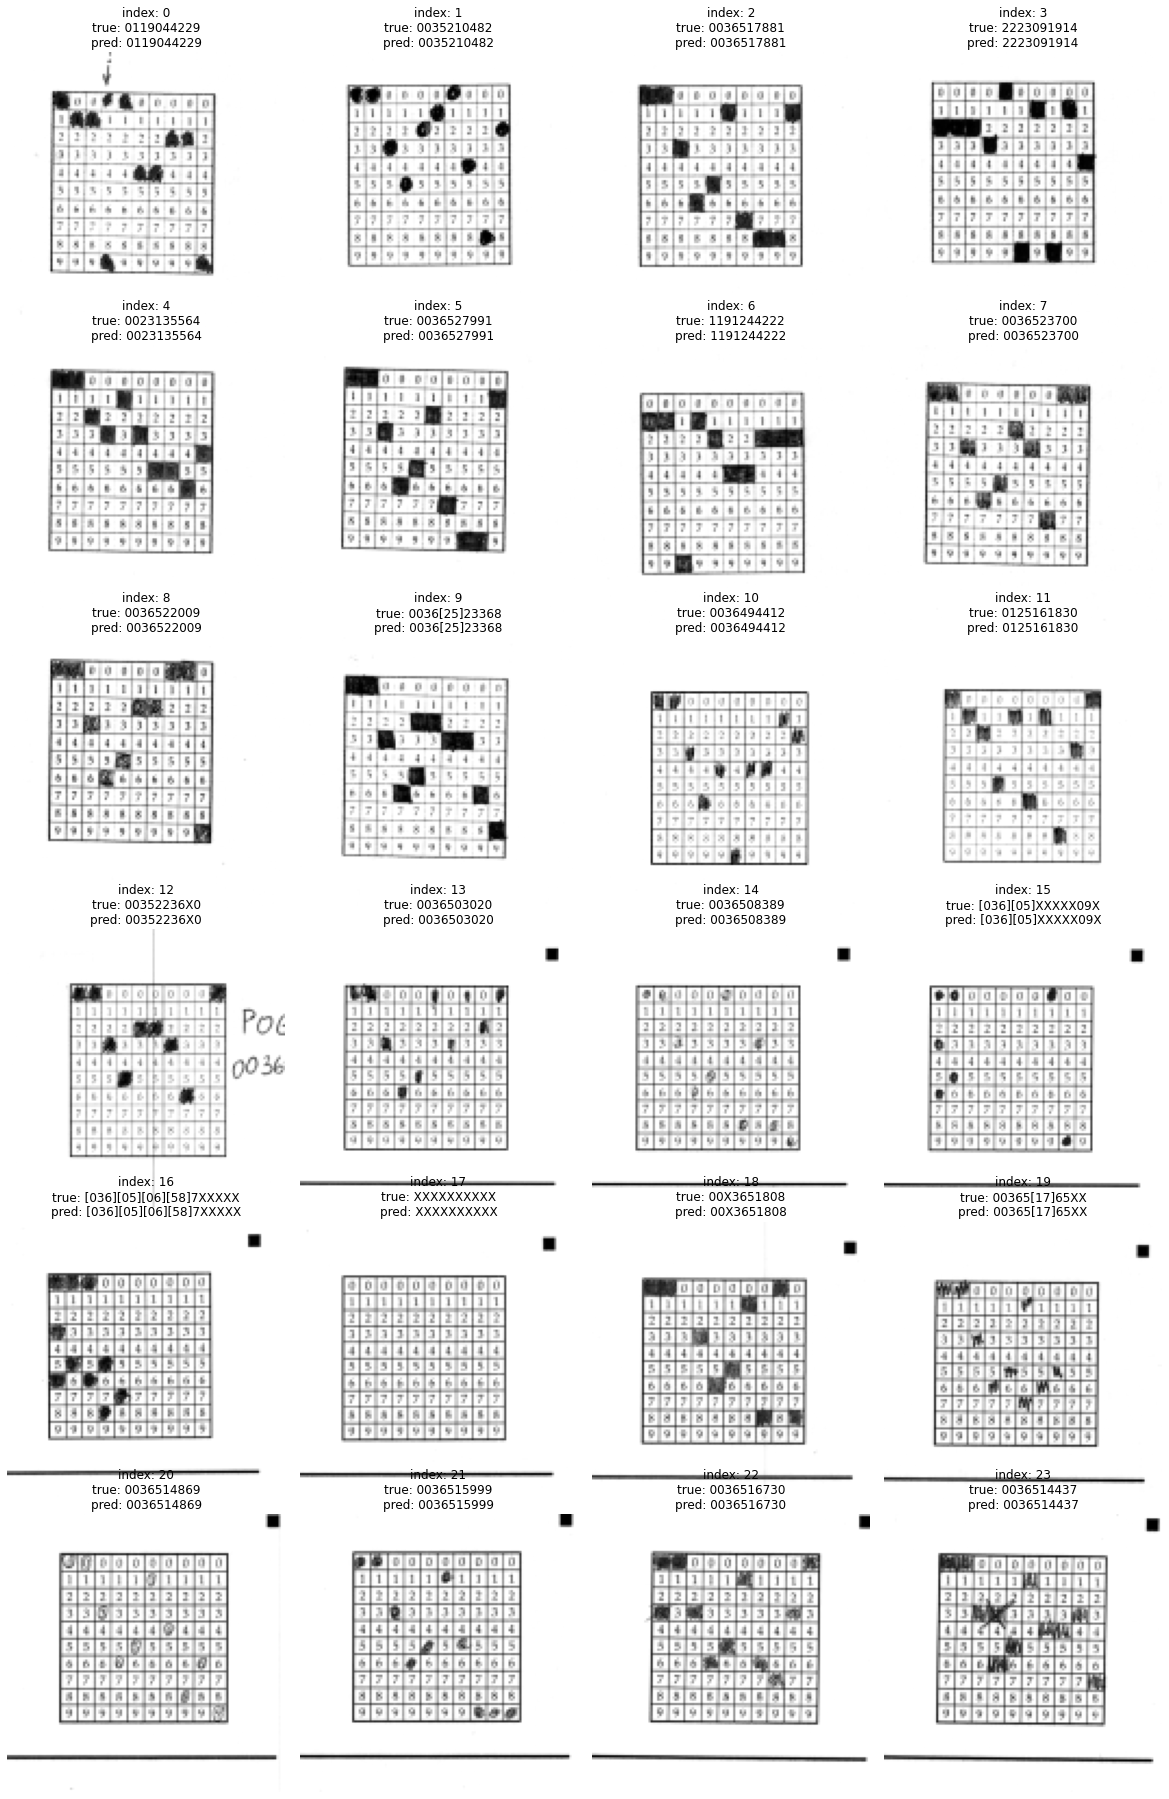

In [48]:
fig = plt.figure(figsize=(24., 32.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 4),
                 axes_pad=0.2 
                 )

for index, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    if index >= len(filtered_annotation): break
    ax.imshow(filtered_images[index][...,-1], cmap = "gray")
    true_str = filtered_df.loc[filtered_df['file'] == filtered_annotation[index][0], 'true_label'].values[0]
    pred_str = filtered_df.loc[filtered_df['file'] == filtered_annotation[index][0], 'predited_label'].values[0]
    ax.set_title(f"index: {index}\ntrue: {true_str}\npred: {pred_str}")
    ax.axis("off")

plt.show()